# Hilbert Space Approximation Gaussian Process Module

In this notebook we provide an example on how to use the **Hilbert Space Gaussian Process** module. We use a synthetic data set to illustrate the usage of some of the kernel approximation functions provided in the module.

**Remark**: This example was taken from the original blog post [A Conceptual and Practical Introduction to Hilbert Space GPs Approximation Methods](https://juanitorduz.github.io/hsgp_intro/).

## Prepare Notebook

In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz

In [2]:
import os

import arviz as az
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

plt.rcParams["figure.figsize"] = [10, 6]

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

assert numpyro.__version__.startswith("0.17.0")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We generate synthetic data in a one-dimensional space. We split the data into training and test sets.

In [3]:
def generate_synthetic_data(rng_key, start, stop: float, num, scale):
    x = jnp.linspace(start=start, stop=stop, num=num)
    y = jnp.sin(4 * jnp.pi * x) + jnp.sin(7 * jnp.pi * x)
    y_obs = y + scale * random.normal(rng_key, shape=(num,))
    return x, y, y_obs


n_train = 80
n_test = 100
scale = 0.3

rng_key, rng_subkey = random.split(rng_key)
x_train, y_train, y_train_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=0, stop=1, num=n_train, scale=scale
)

rng_key, rng_subkey = random.split(rng_key)
x_test, y_test, y_test_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=-0.2, stop=1.2, num=n_test, scale=scale
)

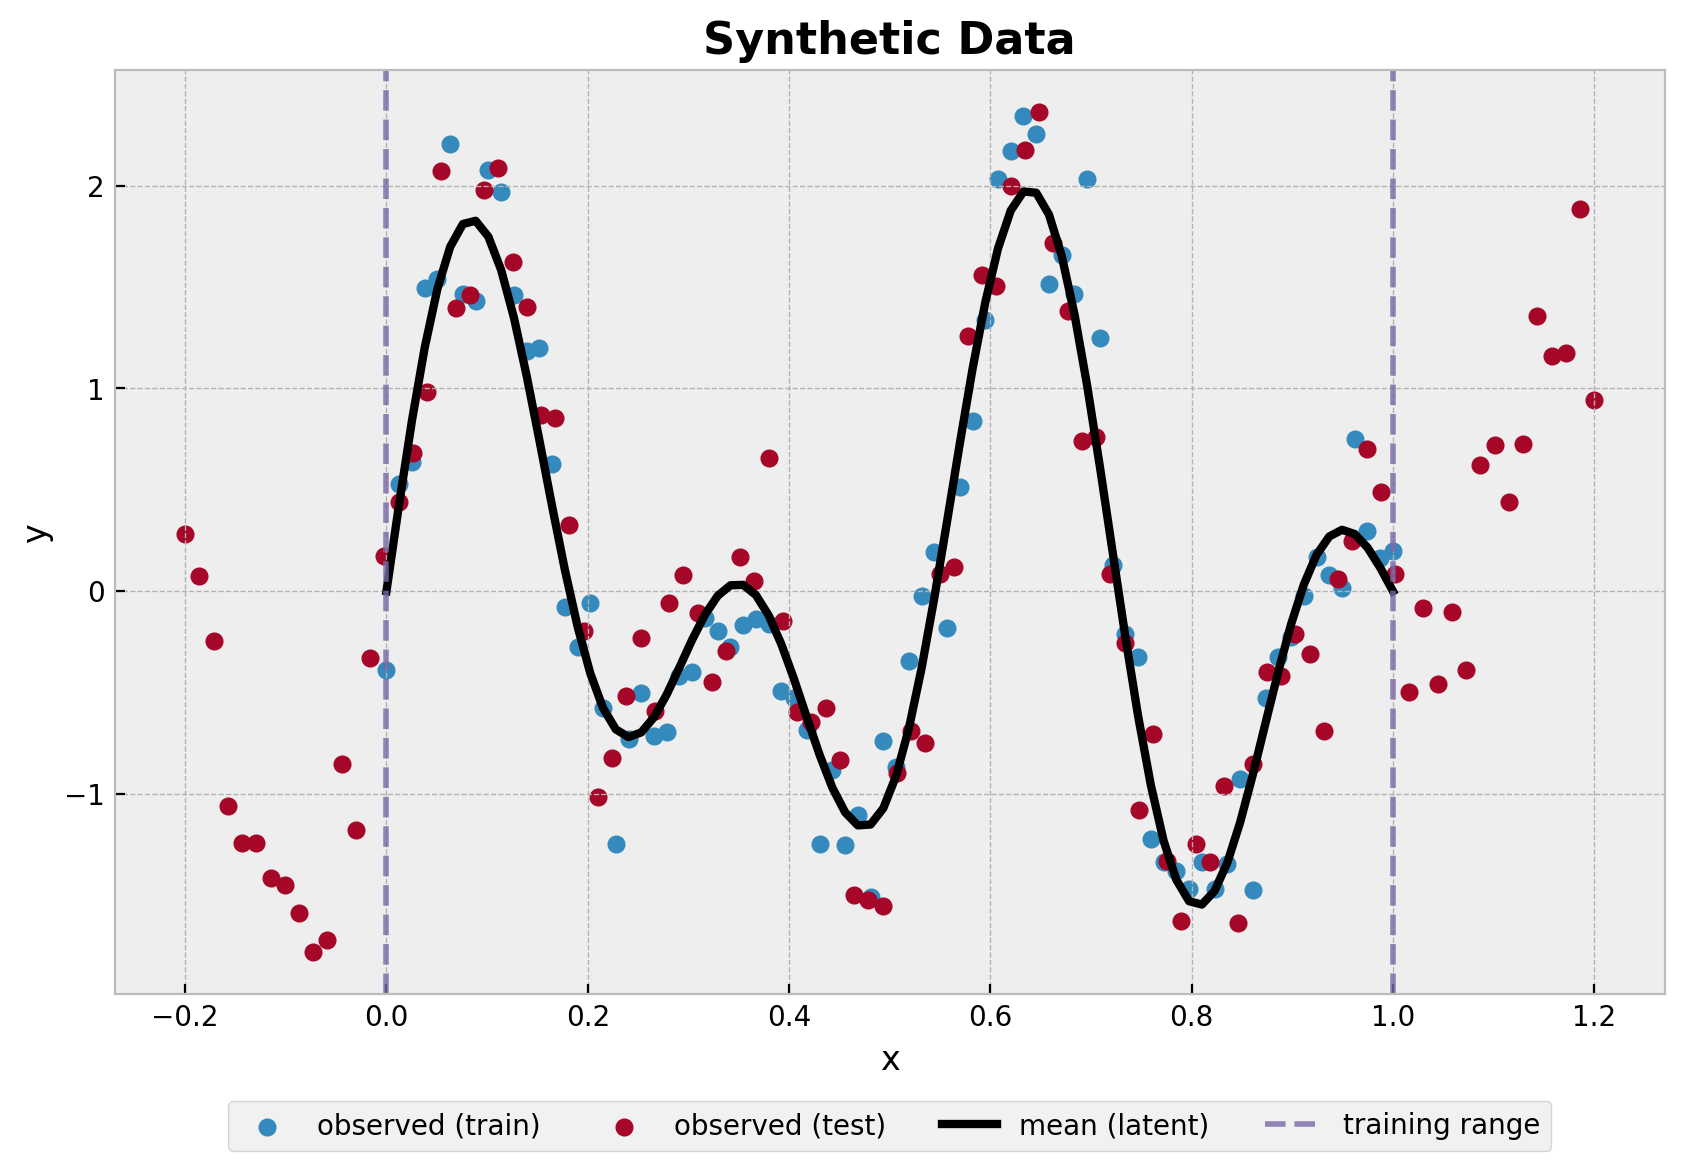

In [4]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.axvline(x=0, color="C2", alpha=0.8, linestyle="--", linewidth=2)
ax.axvline(
    x=1, color="C2", linestyle="--", alpha=0.8, linewidth=2, label="training range"
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Synthetic Data", fontsize=16, fontweight="bold");

It is recommended to center the data before using the approximation functions.

In [5]:
train_mean = x_train.mean()
x_train_centered = x_train - train_mean
x_test_centered = x_test - train_mean

## Specify the Model

We now specify the model. We will use the squared exponential kernel to model the mean of a Gaussian likelihood. This kernel function depends on two parameters: 

- The amplitude `alpha`.
- The length scale `length`.

For these two parameters, we need to specify prior distributions.

Next, we use the function `hsgp_squared_exponential` to approximate the kernel function with the basis functions. We need to specify if we want the `centered` or `non-centered` parameterization of the linear model approximation.

In [6]:
def model(x, ell, m, non_centered, y=None):
    # --- Priors ---
    alpha = numpyro.sample("alpha", dist.InverseGamma(concentration=12, rate=10))
    length = numpyro.sample("length", dist.InverseGamma(concentration=6, rate=1))
    noise = numpyro.sample("noise", dist.InverseGamma(concentration=12, rate=10))
    # --- Parametrization ---
    f = hsgp_squared_exponential(
        x=x, alpha=alpha, length=length, ell=ell, m=m, non_centered=non_centered
    )
    # --- Likelihood ---
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("likelihood", dist.Normal(loc=f, scale=noise), obs=y)

## Fit the Model

For this example we will use `ell=0.8` (since we centered the data),  `m=20` and the `non-centered` parameterization.

Now we fit the model to the data using the NUTS sampler.

In [7]:
sampler = NUTS(model)
mcmc = MCMC(sampler=sampler, num_warmup=1_000, num_samples=2_000, num_chains=4)

rng_key, rng_subkey = random.split(rng_key)

ell = 0.8
m = 20
non_centered = True

mcmc.run(rng_subkey, x_train_centered, ell, m, non_centered, y_train_obs)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Let's see the model diagnostics and posterior distribution of the parameters.

In [8]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(
    data=idata,
    var_names=["alpha", "length", "noise", "beta"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.169,0.340,0.616,1.794,0.005,0.004,5411.0,4996.0,1.0
length,0.083,0.010,0.064,0.101,0.000,0.000,4356.0,5364.0,1.0
noise,0.332,0.030,0.276,0.386,0.000,0.000,8324.0,6009.0,1.0
beta[0],0.032,0.192,-0.323,0.401,0.003,0.002,3893.0,5326.0,1.0
beta[1],0.112,0.337,-0.532,0.726,0.005,0.004,3905.0,4980.0,1.0
beta[2],-0.039,0.465,-0.873,0.875,0.008,0.006,3564.0,4845.0,1.0
beta[3],0.286,0.542,-0.704,1.328,0.009,0.006,3770.0,4762.0,1.0
beta[4],-0.305,0.583,-1.359,0.798,0.010,0.007,3376.0,4314.0,1.0
beta[5],-1.862,0.600,-2.983,-0.733,0.009,0.007,4133.0,4779.0,1.0
beta[6],-0.527,0.560,-1.579,0.522,0.010,0.007,3183.0,3904.0,1.0


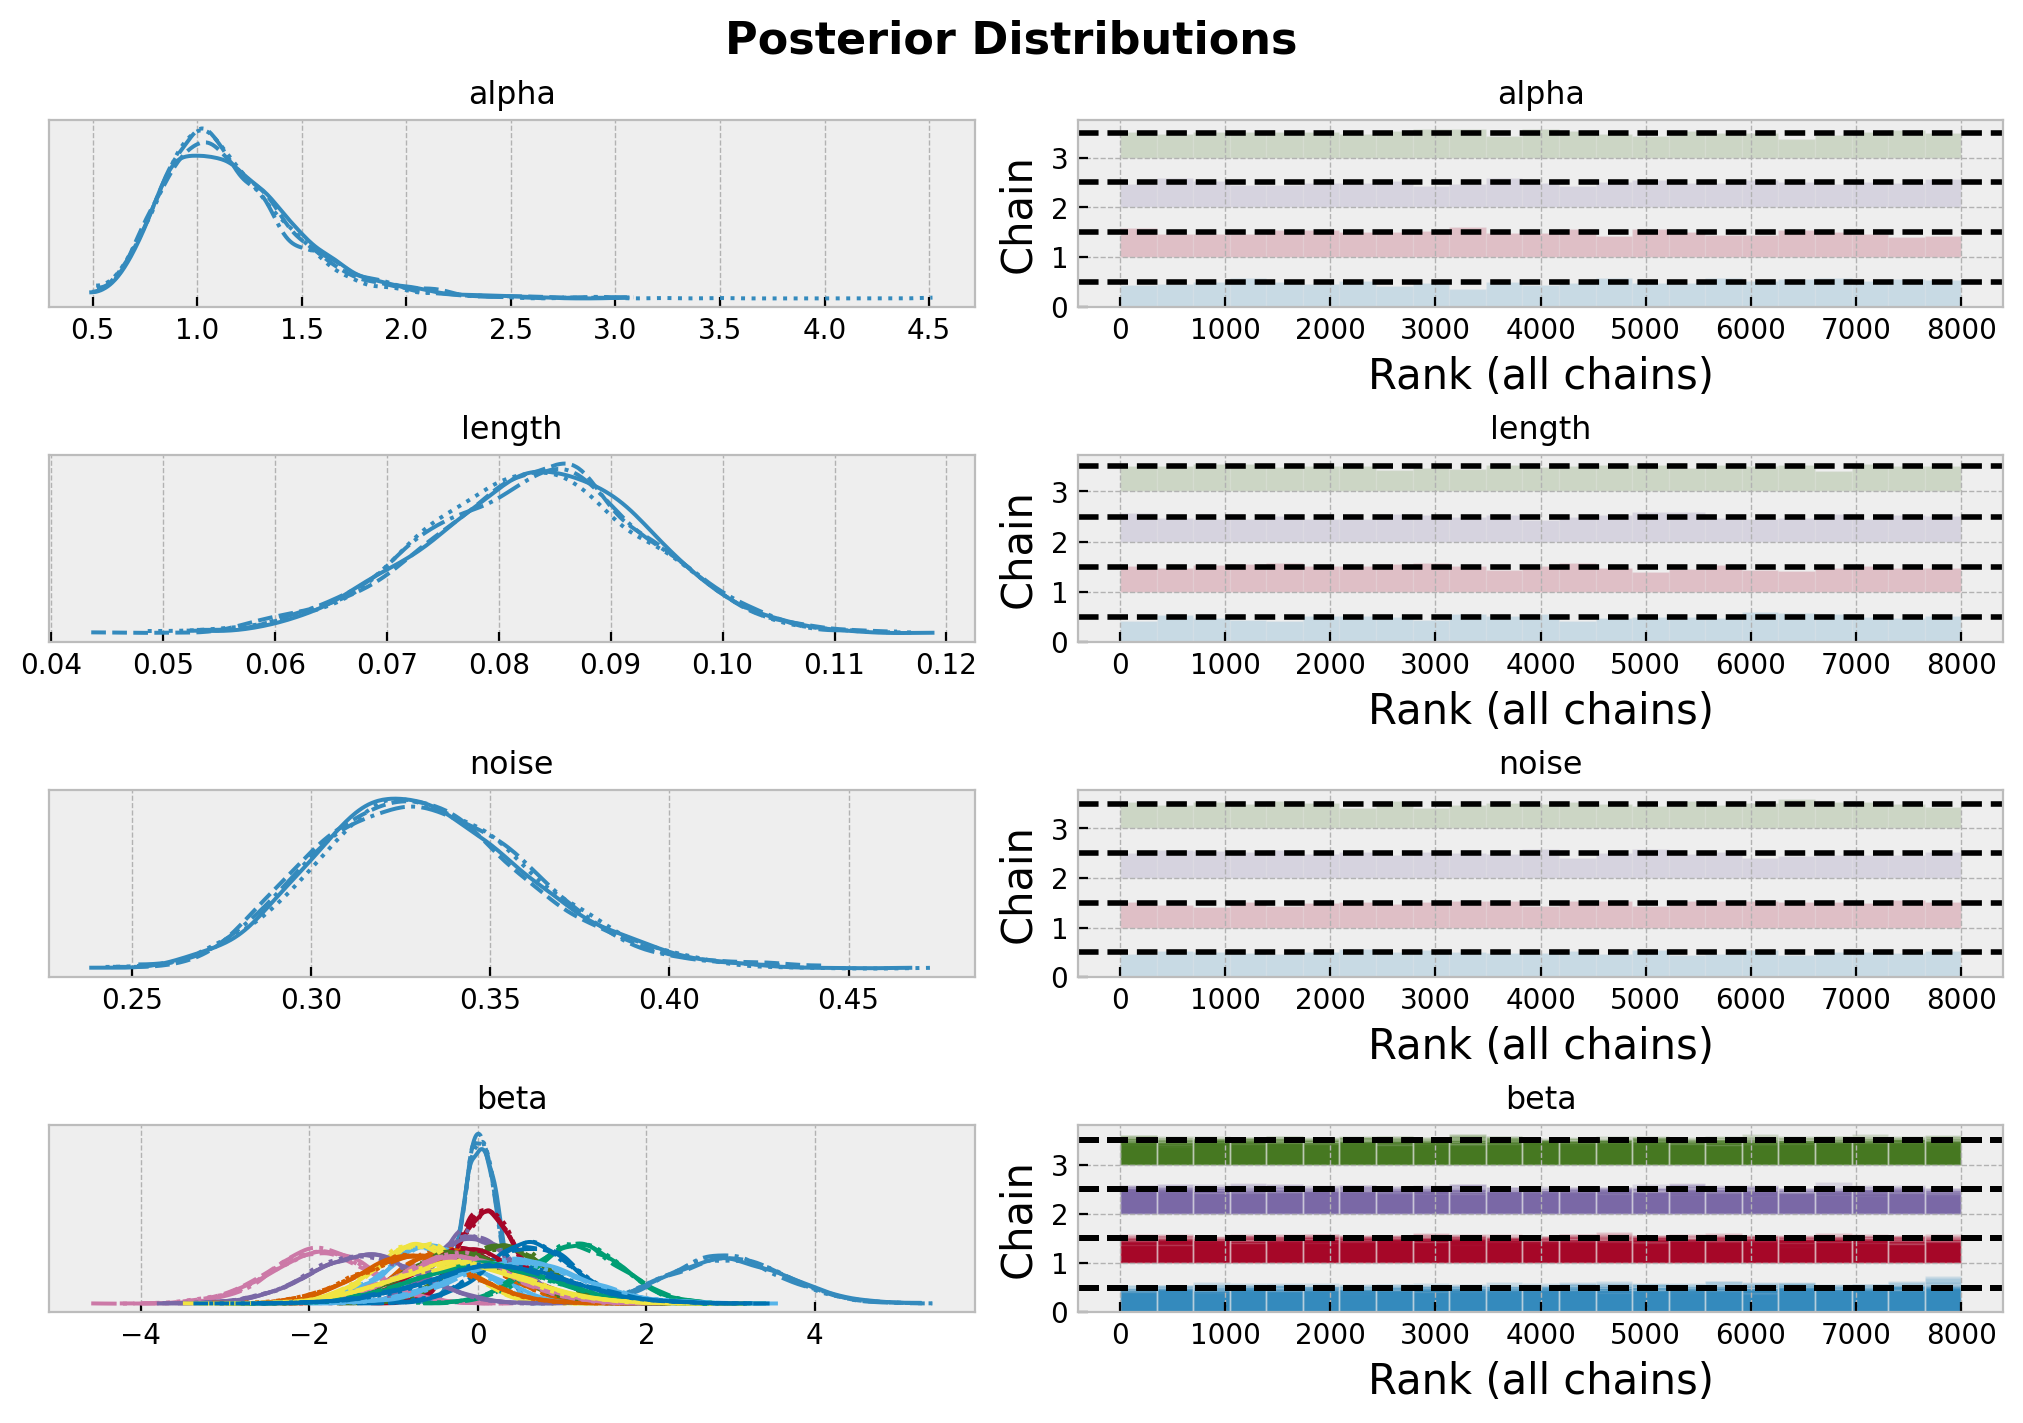

In [9]:
axes = az.plot_trace(
    data=idata,
    var_names=["alpha", "length", "noise", "beta"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Posterior Distributions", fontsize=16, fontweight="bold");

Overall, the model seems to have converged well.

## Posterior Predictive Distribution

Finally, we generate samples from the posterior predictive distribution on thee test set and plot the results.

In [10]:
predictive = Predictive(model, mcmc.get_samples())
posterior_predictive = predictive(rng_subkey, x_test_centered, ell, m, non_centered)
rng_key, rng_subkey = random.split(rng_key)

idata.extend(az.from_numpyro(posterior_predictive=posterior_predictive))

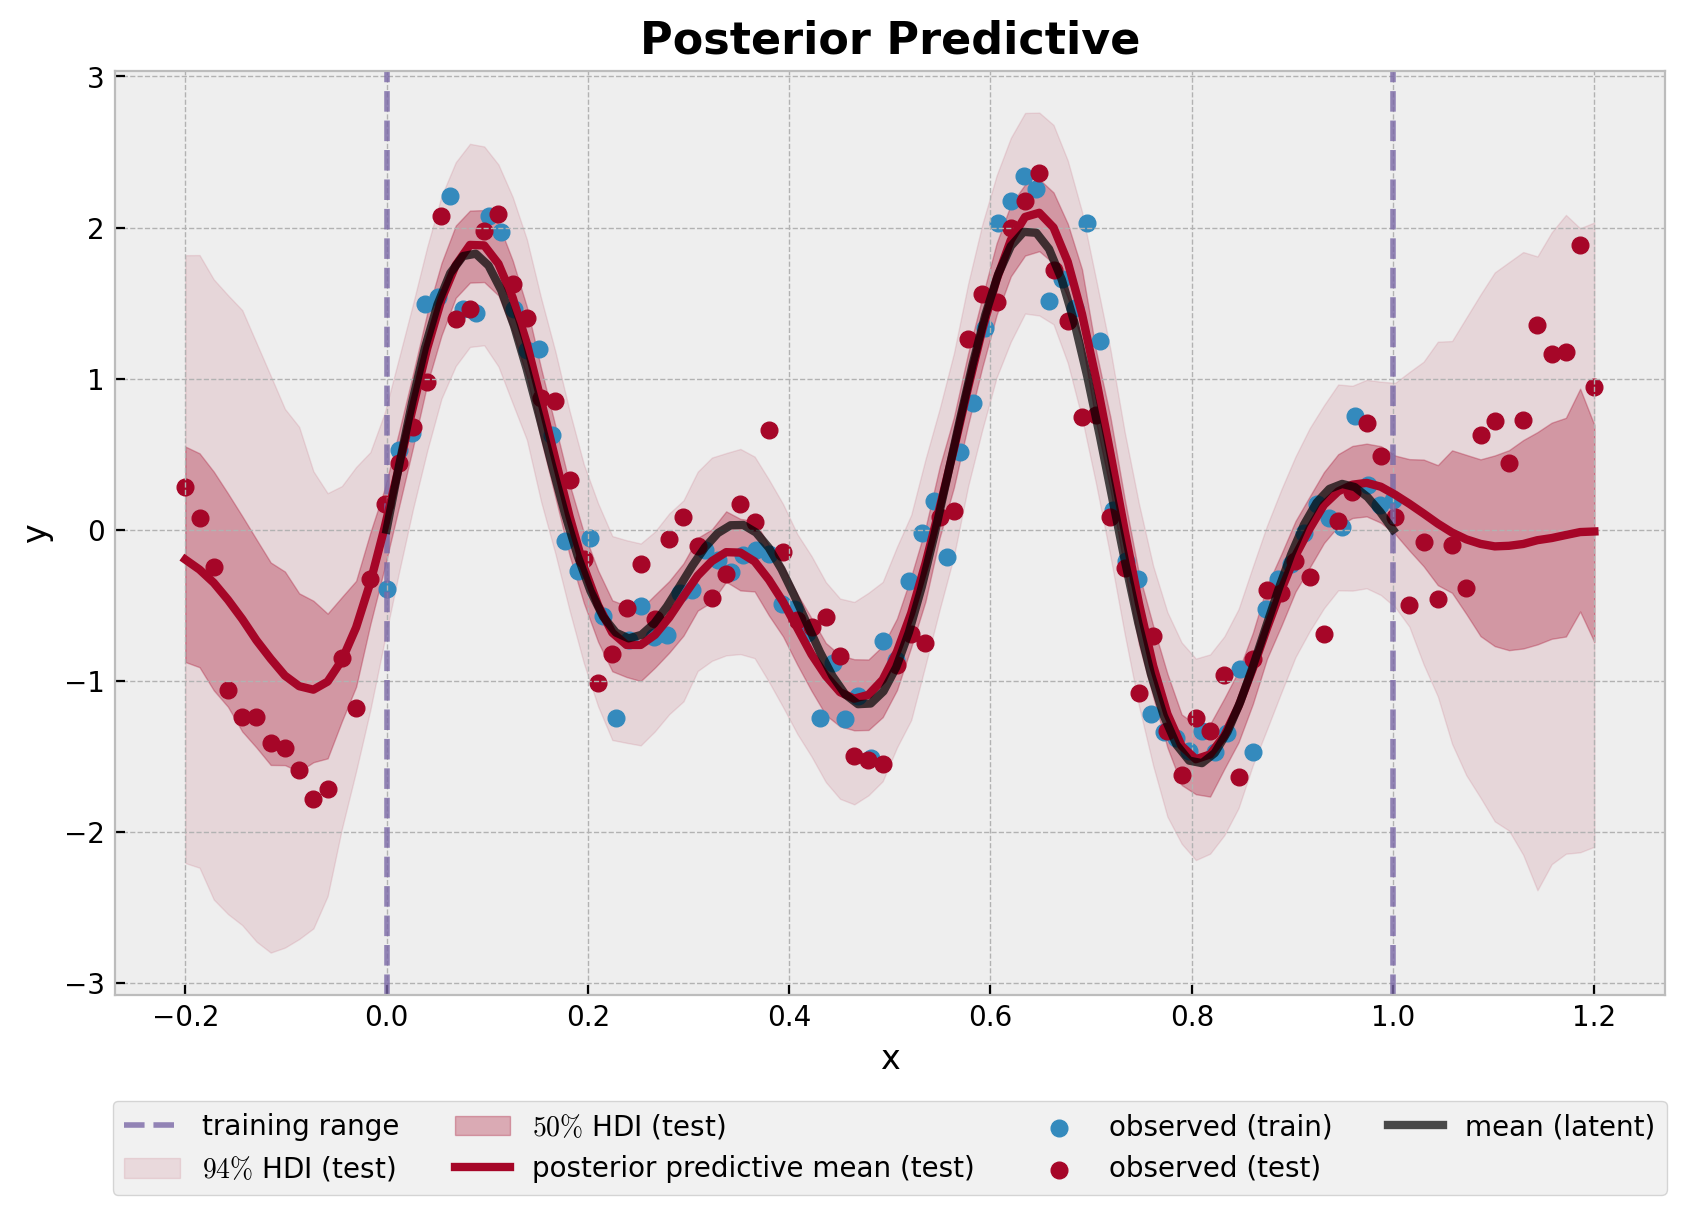

In [11]:
fig, ax = plt.subplots()
ax.axvline(x=0, color="C2", alpha=0.8, linestyle="--", linewidth=2)
ax.axvline(
    x=1, color="C2", linestyle="--", alpha=0.8, linewidth=2, label="training range"
)
az.plot_hdi(
    x_test,
    idata.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.1, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    idata.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    idata.posterior_predictive["likelihood"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Posterior Predictive", fontsize=16, fontweight="bold");

The model did a good job of capturing the underlying function in the training set region. The uncertainty increases as we move away from the training set.

----

## Idea of the Hilbert Space Approximation?

In this notebook we do not go into the details of the Hilbert Space Approximation. However, here we sketch the main idea.

We approximate the kernel function with a set of basis functions $\phi_{j}$ coming from the spectrum of thee Dirichlet Laplacian in the box `[-ell, ell]`. There basis functions are independent of the kernel hyperparameters `alpha` and `length`! The weights of these basis functions come from evaluating the spectral density $S(\omega)$ of the kernel function at the square roots of thee eigenvalues $\lambda_{j}$ of the Dirichlet Laplacian. The final approximation formula looks like:

$$
    f(x) \approx \sum_{j = 1}^{m} 
    \overbrace{\color{red}{\left(S(\sqrt{\lambda_j})\right)^{1/2}}}^{\text{all hyperparameters are here!}} 
    \times
    \underbrace{\color{blue}{\phi_{j}(x)}}_{\text{easy to compute!}}
    \times
    \overbrace{\color{green}{\beta_{j}}}^{\sim \: \text{Normal}(0,1)}
$$

Let's see the approximation components. First, we plot the basis functions.

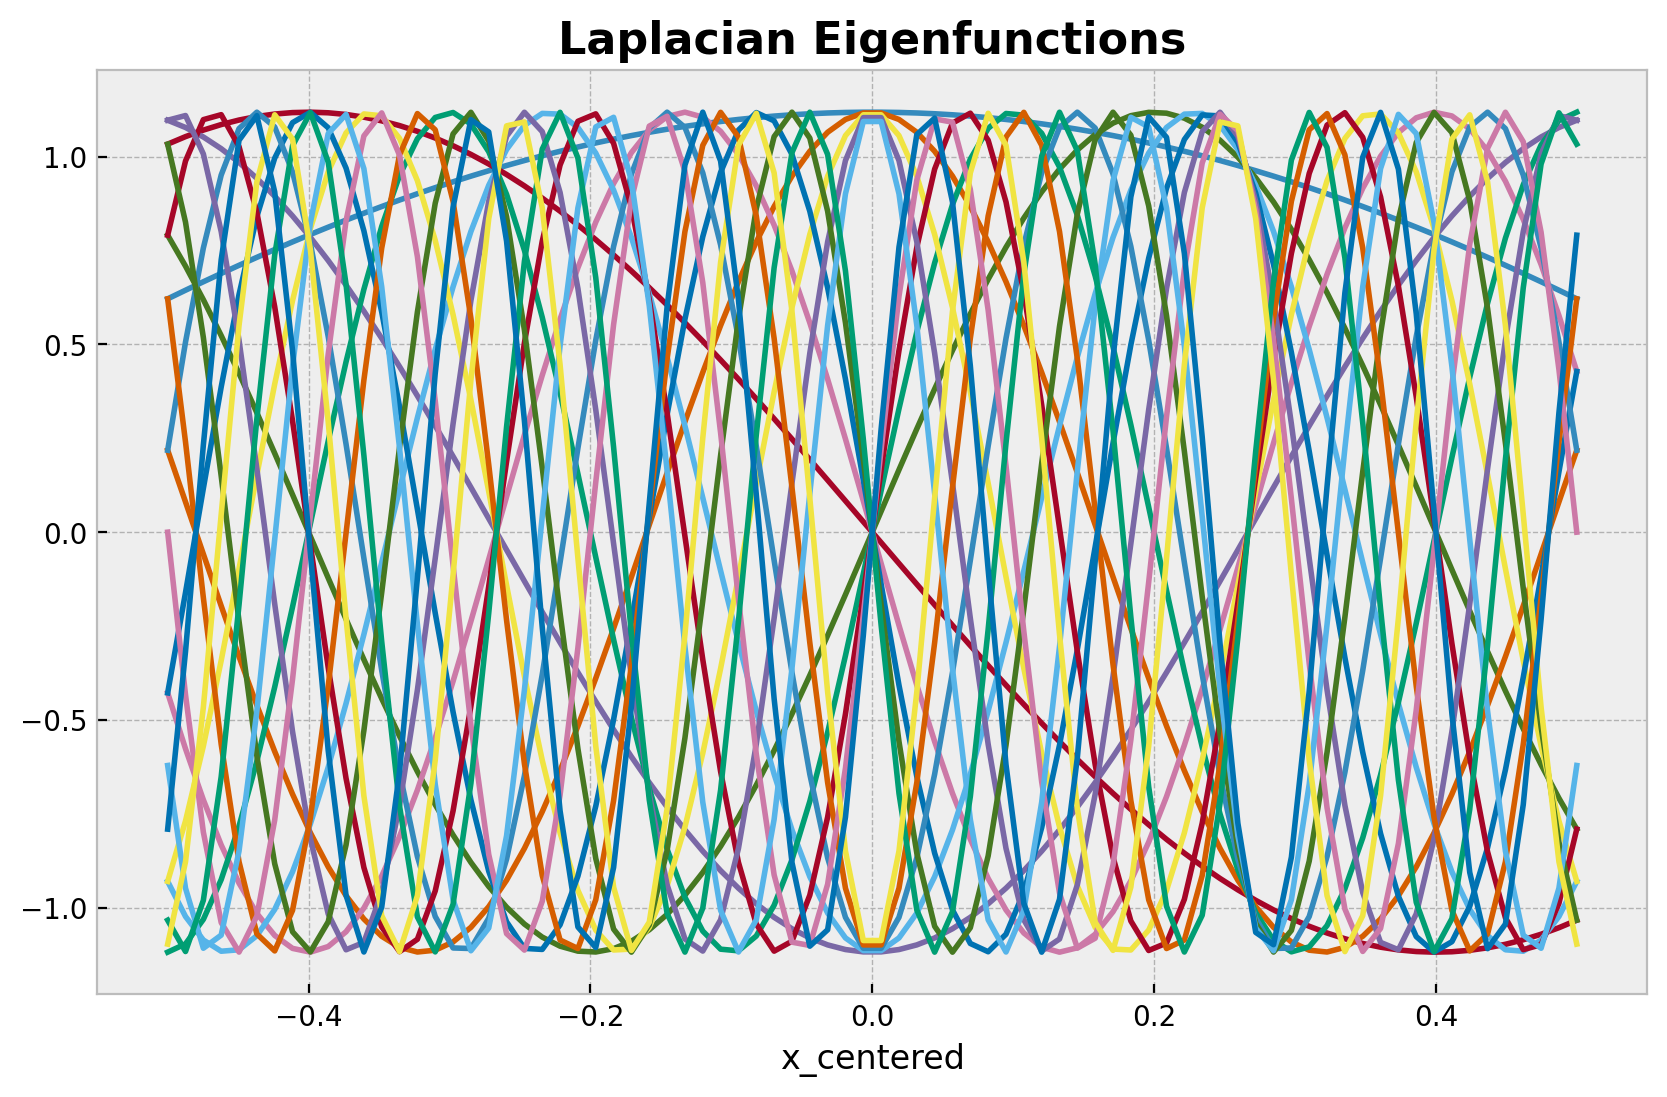

In [12]:
basis = eigenfunctions(x=x_train_centered, ell=ell, m=m)

fig, ax = plt.subplots()
ax.plot(x_train_centered, basis)
ax.set(xlabel="x_centered")
ax.set_title("Laplacian Eigenfunctions", fontsize=16, fontweight="bold");

These are weighted by spectral density values. The following plot shows the spectral evaluated on the square roots of the eigenvalues of the Dirichlet Laplacian.
We use various values of the hyperparameters `alpha` and `length` to see how the spectral density changes. we also include in black the corresponding spectral density using the posterior mean inferred from the model above.

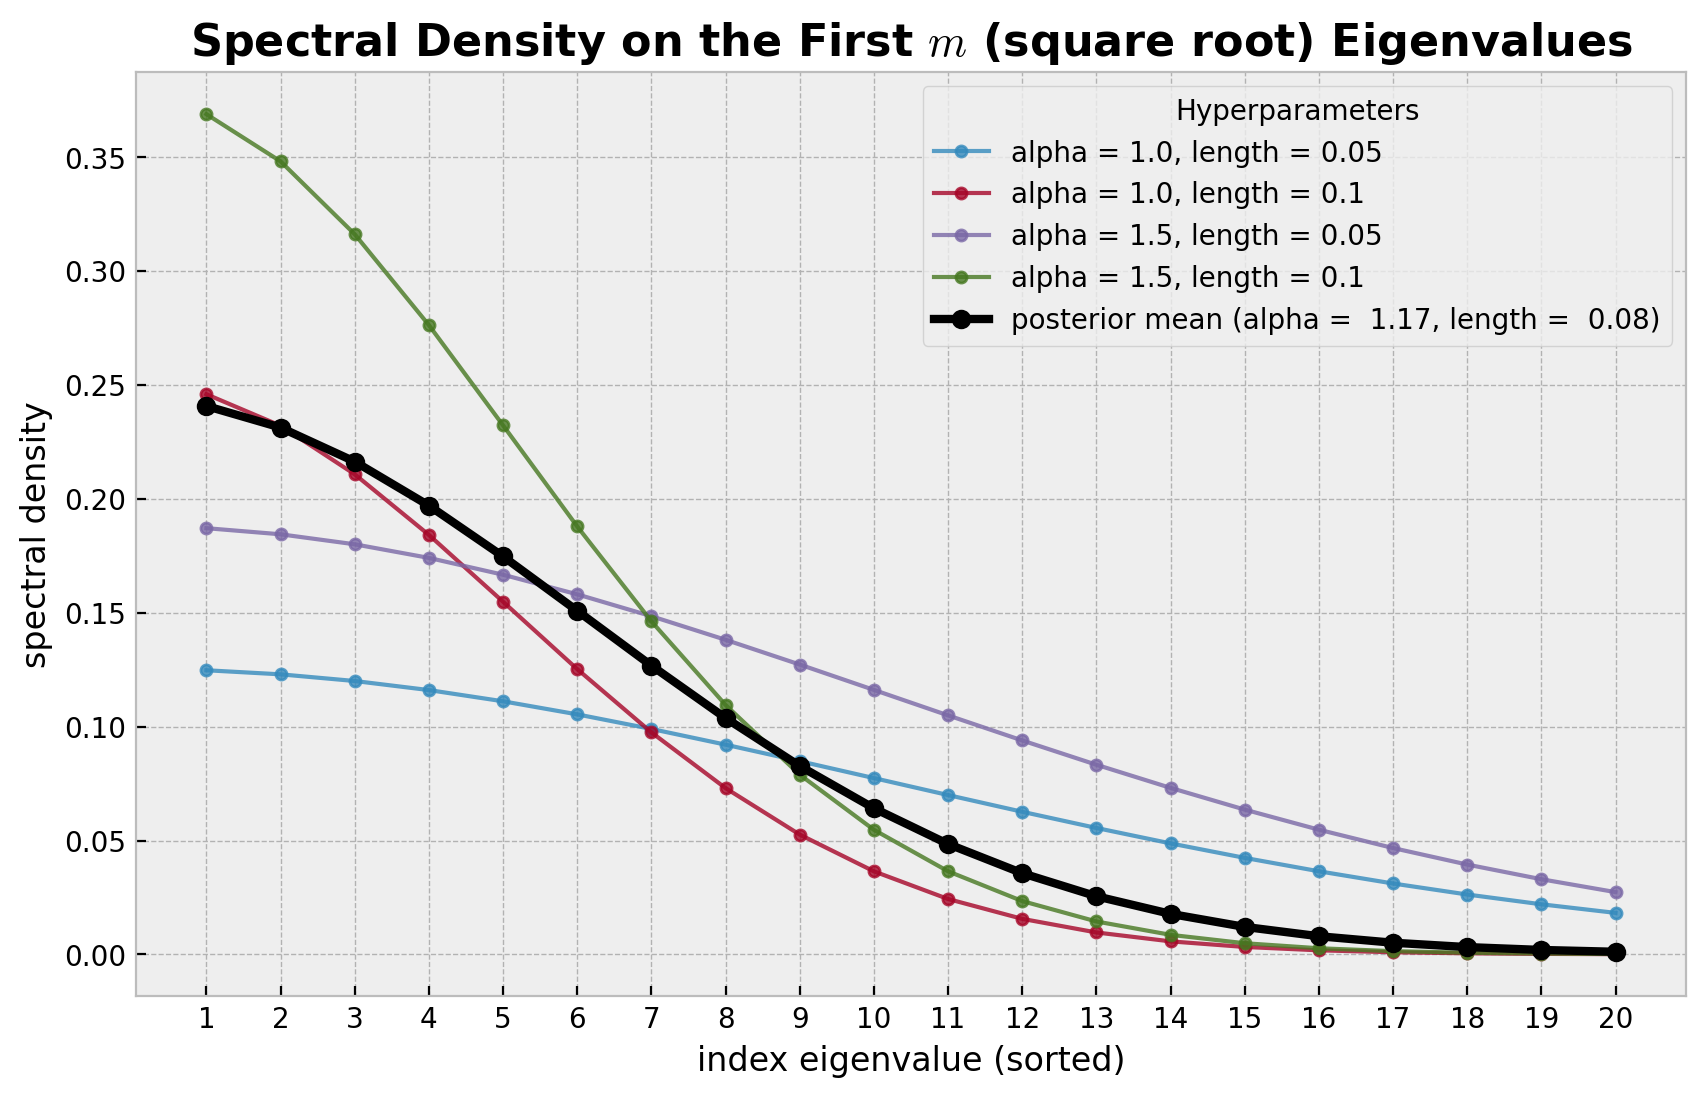

In [14]:
alpha_posterior_mean = idata.posterior["alpha"].mean(dim=("chain", "draw")).item()
length_posterior_mean = idata.posterior["length"].mean(dim=("chain", "draw")).item()

fig, ax = plt.subplots()
ax.set(xlabel="index eigenvalue (sorted)", ylabel="spectral density")

for alpha_value in (1.0, 1.5):
    for length_value in (0.05, 0.1):
        diag_sd = diag_spectral_density_squared_exponential(
            alpha=alpha_value,
            length=length_value,
            ell=ell,
            m=m,
            dim=1,
        )
        ax.plot(
            range(1, m + 1),
            diag_sd,
            marker="o",
            linewidth=1.5,
            markersize=4,
            alpha=0.8,
            label=f"alpha = {alpha_value}, length = {length_value}",
        )

diag_sd = diag_spectral_density_squared_exponential(
    alpha=alpha_posterior_mean,
    length=length_posterior_mean,
    ell=ell,
    m=m,
    dim=1,
)
ax.plot(
    range(1, m + 1),
    diag_sd,
    marker="o",
    color="black",
    linewidth=3,
    markersize=6,
    label=f"posterior mean (alpha = {alpha_posterior_mean: .2f}, length = {length_posterior_mean: .2f})",
)
ax.xaxis.set_major_locator(MultipleLocator())
ax.legend(loc="upper right", title="Hyperparameters")
ax.set_title(
    r"Spectral Density on the First $m$ (square root) Eigenvalues",
    fontsize=16,
    fontweight="bold",
);

As the spectral density decays to zero at higher frequencies, the effect of the larger eigenvalues becomes smaller. One can prove that in the limit, the Hilbert space approximation converges to the true kernel function.